In [7]:
import pandas as pd
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
import urllib.request
import json
from matplotlib import rcParams

In [65]:
rcParams['figure.figsize'] = 9,6
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
rcParams['legend.fontsize'] = 14
#rcParams['lines.linewidth'] = 2.25
rcParams['lines.markersize'] = 9
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [9]:
import seaborn as sns
sns.set()
del sns

In [10]:
def nod(year, month):
    if month == 4 or month == 6 or month == 9 or month == 11:
        days = 30
    elif month == 2:
        days = 29 if year % 4 == 0 else 28
    else:
        days = 31
    return days
def create_dates(start_year, end_year):
    days = 0
    for i in range(start_year, end_year + 1):
        day_y = 366 if (i % 4) == 0 else 365
        days += day_y
    year = start_year
    month = 1
    day = 0
    dates = []
    for i in range(0, days):    
        if day < nod(year, month):
            day += 1
        else:
            day = 1        
            if month < 12:
                month += 1
            else:
                year += 1
                month = 1
        ms = '0' + str(month) if month<10 else str(month)
        ds = '0' + str(day) if day<10 else str(day)
        dates.append(str(year) + ms + ds)
    dates_int = [int(x) for x in dates]
    return dates, dates_int

In [11]:
def findval(df, lat, lon):
    latstr = list(df)[0]
    lonstr = list(df)[1]
    df = df[df[latstr]==lat]
    df = df[df[lonstr]==lon]
    val = df['Value'].item()
    return val
def interpval(df, lat=1, lon=1):
    lat_0 = df['Latitude'].iloc[2]
    lat_1 = df['Latitude'].iloc[0]
    lon_a = df['Longitude'].iloc[0]
    lon_b = df['Longitude'].iloc[1]
    t = (lat - lat_0) / (lat_1 - lat_0)
    s = (lon - lon_a) / (lon_b - lon_a)
    X_tl = findval(df, lat_1, lon_a)
    X_tr = findval(df, lat_1, lon_b)
    X_bl = findval(df, lat_0, lon_a)
    X_br = findval(df, lat_0, lon_b)
    value = (1 - s) * (1 - t) * X_bl + (1 - s) * t * X_tl + s * (1 - t) * X_br + t * s * X_tr
    return value
def savelist(array, name='file'):
    name = name + '.txt'
    with open(name, "w") as f:
        for s in array:
            f.write(str(s) +"\n")

In [50]:
def find_iv(rd, output, start_year, end_year, hours, lat, lon, datafreq='d', outputname='itcwv'):
    start_time = time.time()
    hours = [hours] if type(hours)!=list else hours
    name = rd[::-1][rd[::-1].find('.')+1:rd[::-1].find('/')][::-1]
    txt_name = name + '.txt'
    output_path = output + txt_name
    command = 'grib_get_data -p dataDate,dataTime ' + rd + ' > ' + output_path
    os.system(command)
    df = pd.read_csv(output_path, sep='\s+')
    col_ind = list(df)
    ncol_ind = [x.replace(',','') for x in col_ind]
    df.columns = ncol_ind
    df = df[~df['Latitude'].isin(['Latitude,'])]
    col_ind = list(df)
    for i in col_ind:
        df[i] = pd.to_numeric(df[i])
    if isinstance(a, int):
        dates = create_dates(start_year, end_year)[1] if datafreq=='d' else create_mdates(start_year, end_year)[1]
    else:
        dates = pd.date_range(start_year, end_year, freq=datafreq).strftime('%Y%m%d').tolist()
        dates = [int(i) for i in dates]
    for i in hours:
        tcwv_i = []
        hs = f"{int(i/100):02d}"
        hdf = df[df['dataTime']==i]
        for j in dates:
            ddf = hdf[hdf['dataDate']==j]
            iv = interpval(ddf, lat, lon)
            tcwv_i.append(iv)
        path = output + outputname + '_' + hs
        savelist(tcwv_i, path)
    print("--- %.6s seconds ---" % (time.time() - start_time))

In [13]:
hourarray = np.arange(0,2400,100).tolist()
#hourarray = [str(i) for i in hourarray]

### 1950 to 1959

In [12]:
startyear = 1950
endyear = 1959
hourarray = np.arange(0,2400,100).tolist()
latitude = -16.51
longitude = -68.17
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-50-59.grib'
outputpath = '/home/gustavo/Downloads/tcwv/interp/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 614.90 seconds ---


### 1960 to 1969

In [14]:
startyear = 1960
endyear = 1969
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-60-69.grib'
os.system('mkdir /home/gustavo/Downloads/tcwv/interp/tcwv-60-69/')
outputpath = '/home/gustavo/Downloads/tcwv/interp/tcwv-60-69/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 611.07 seconds ---


### 1970 to 1978

In [15]:
startyear = 1970
endyear = 1978
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-70-78.grib'
os.system('mkdir /home/gustavo/Downloads/tcwv/interp/tcwv-70-78/')
outputpath = '/home/gustavo/Downloads/tcwv/interp/tcwv-70-78/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 543.79 seconds ---


### 1979 to 1991

In [16]:
startyear = 1979
endyear = 1991
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-79-91.grib'
os.system('mkdir /home/gustavo/Downloads/tcwv/interp/tcwv-79-91/')
outputpath = '/home/gustavo/Downloads/tcwv/interp/tcwv-79-91/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 776.77 seconds ---


### 1992 to 2004

In [17]:
startyear = 1992
endyear = 2004
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-92-04.grib'
os.system('mkdir /home/gustavo/Downloads/tcwv/interp/tcwv-92-04/')
outputpath = '/home/gustavo/Downloads/tcwv/interp/tcwv-92-04/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 752.04 seconds ---


### 2005 to 2011

In [18]:
startyear = 2005
endyear = 2011
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-05-11.grib'
os.system('mkdir /home/gustavo/Downloads/tcwv/interp/tcwv-05-11/')
outputpath = '/home/gustavo/Downloads/tcwv/interp/tcwv-05-11/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 404.72 seconds ---


### 2012 to 2019

In [19]:
startyear = 2012
endyear = 2019
inputpath = '/home/gustavo/Downloads/tcwv/tcwv-12-19.grib'
os.system('mkdir /home/gustavo/Downloads/tcwv/interp/tcwv-12-19/')
outputpath = '/home/gustavo/Downloads/tcwv/interp/tcwv-12-19/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude)

--- 462.08 seconds ---


In [21]:
strhour = [str(i) for i in hourarray]
for i in strhour:
    os.system('mkdir /home/gustavo/Downloads/tcwv/interp/' + i)

In [44]:
f1 = os.listdir('/home/gustavo/Downloads/tcwv/interp/1-tcwv-50-59/')
f2 = os.listdir('/home/gustavo/Downloads/tcwv/interp/2-tcwv-60-69/')
f3 = os.listdir('/home/gustavo/Downloads/tcwv/interp/3-tcwv-70-78/')
f4 = os.listdir('/home/gustavo/Downloads/tcwv/interp/4-tcwv-79-91/')
f5 = os.listdir('/home/gustavo/Downloads/tcwv/interp/5-tcwv-92-04/')
f6 = os.listdir('/home/gustavo/Downloads/tcwv/interp/6-tcwv-05-11/')
f7 = os.listdir('/home/gustavo/Downloads/tcwv/interp/7-tcwv-12-19/')
ff = ['/home/gustavo/Downloads/tcwv/interp/1-tcwv-50-59/', 
      '/home/gustavo/Downloads/tcwv/interp/2-tcwv-60-69/', 
      '/home/gustavo/Downloads/tcwv/interp/3-tcwv-70-78/',
      '/home/gustavo/Downloads/tcwv/interp/4-tcwv-79-91/',
      '/home/gustavo/Downloads/tcwv/interp/5-tcwv-92-04/',
      '/home/gustavo/Downloads/tcwv/interp/6-tcwv-05-11/',
      '/home/gustavo/Downloads/tcwv/interp/7-tcwv-12-19/'
     ]
fe = [f1, f2, f3, f4, f5, f6, f7]

In [43]:
i = 1
for j in ff:
    # print(j + str(i))
    for k in fe[i-1]:
        currname = j + k
        newname = j + str(i) + '-' + k
        os.rename(currname, newname)
    i += 1

In [52]:
i = 0
for j in ff:
    print(j)
    for k in fe[i]:
        strhour = k[-6:-4]
        inthour = int(k[-6:-4]) * 100
        currentpath = j + k
        newpath = '/home/gustavo/Downloads/tcwv/interp/' + str(inthour) + '/' + k
        os.replace(currentpath, newpath)
    i += 1

/home/gustavo/Downloads/tcwv/interp/1-tcwv-50-59/
/home/gustavo/Downloads/tcwv/interp/2-tcwv-60-69/
/home/gustavo/Downloads/tcwv/interp/3-tcwv-70-78/
/home/gustavo/Downloads/tcwv/interp/4-tcwv-79-91/
/home/gustavo/Downloads/tcwv/interp/5-tcwv-92-04/
/home/gustavo/Downloads/tcwv/interp/6-tcwv-05-11/
/home/gustavo/Downloads/tcwv/interp/7-tcwv-12-19/


### Function to load text file to a list

In [55]:
def loadlist(array, name='file'):
    with open(name, "r") as f:
        for line in f:
            array.append(float(line.strip()))

### Interpolation for given probabilities

In [56]:
def interp_list(x, y, new_x):
    new_y = []
    y_interp = interp1d(x, y, kind='linear')
    new_y = np.array([float(y_interp(val)) for val in new_x])
    return new_y

### CCDF calculation and plotting

In [57]:
def plotcdf(array, plot=1, bins=50):
    ccdf, X, _ = plt.hist(array, bins = bins, density=True, log=True, cumulative=-1, histtype='step')
    ccdf = np.append(ccdf * 100, 0)
    plt.clf()
    plt.grid(True, which="both")
    plt.semilogy(X, ccdf, label='CCDF')
    plt.legend(loc='best')
    plt.xlabel('IWV (mm)')
    plt.ylabel('Probabilidad (%)')
    plt.title('CCDF')
    plt.show() if plot == 1 else plt.clf()
    return X, ccdf

### Water Vapor Attenuation

In [14]:
wat_file = pd.read_csv('ITUFiles/wat676.csv')
oxy_file = pd.read_csv('ITUFiles/oxy676.csv')
fw = wat_file['fw'].to_numpy()
b1 = wat_file['b1'].to_numpy()
b2 = wat_file['b2'].to_numpy()
b3 = wat_file['b3'].to_numpy()
b4 = wat_file['b4'].to_numpy()
b5 = wat_file['b5'].to_numpy()
b6 = wat_file['b6'].to_numpy()
fo = oxy_file['fo'].to_numpy()
a1 = oxy_file['a1'].to_numpy()
a2 = oxy_file['a2'].to_numpy()
a3 = oxy_file['a3'].to_numpy()
a4 = oxy_file['a4'].to_numpy()
a5 = oxy_file['a5'].to_numpy()
a6 = oxy_file['a6'].to_numpy()

In [15]:
def itu676(f, p, rho, T):
    # p: dry air presure (hPa)
    # e: water vaour partial pressure (hPa)
    # theta (Θ): 300/T
    # T: Temperature
    theta = 300/T
    e = (rho*T)/216.7
    So = a1 * (1e-7) * p * (theta**3) * np.exp(a2 * (1 - theta))
    Sw = b1 * (1e-1) * e * (theta**3.5) * np.exp(b2 * (1 - theta))
    deltao = (a5 + a6 * theta) * (1e-4) * (p + e) * (theta**0.8)
    deltaw = 0
    deltafo_wd = a3 * (1e-4) * (p * (theta**(0.8 - a4)) + 1.1 * e * theta)
    deltafw_wd = b3 * (1e-4) * (p * (theta**b4) + b5 * e * (theta**b6))
    deltafo = np.sqrt(deltafo_wd**2 + 2.25e-6)
    deltafw = 0.535 * deltafw_wd + np.sqrt((0.217 * deltafw_wd**2) + (2.1316e-12 * (fw**2))/(theta))
    Fo = ((f)/(fo)) * (((deltafo - deltao * (fo - f))/(deltafo**2 + (fo - f)**2))+((deltafo - deltao * (fo + f))/(deltafo**2 + (fo + f)**2)))
    Fw = ((f)/(fw)) * (((deltafw - deltaw * (fw - f))/(deltafw**2 + (fw - f)**2))+((deltafw - deltaw * (fw + f))/(deltafw**2 + (fw + f)**2)))
    d = (5.6e-4) * (p + e) * (theta**0.8)
    N2Df = f * p * theta**2 * (((6.14e-5)/(d * (1+(f/d)**2)))+((1.4e-12 * p * theta**1.5)/(1 + 1.9e-5 * f**1.5)))
    N2f = sum(Fo * So) + sum(Fw * Sw) + N2Df
    y = 0.182 * f * N2f
    ywv = 0.182 * f * sum(Fw * Sw)
    yox = 0.182 * f * (sum(Fo * So) + N2Df)
    return y, ywv, yox

In [16]:
def get_elevation(lat, lon):
    key = 'Ai9NLeGblweg0P_Br_bKnbLVkkRgbG6RlH4k5FrbBctSqD32KHMuFQmRyX-apadI'
    url = 'https://dev.virtualearth.net/REST/v1/Elevation/List?key=' + key + '&points=' + str(lat) + ',' + str(lon)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read().decode())
    elevation = data['resourceSets'][0]['resources'][0]['elevations'][0]
    return elevation, elevation / 1000

In [17]:
def calc_at(daily_tcwv, freq, lat, lon):
    freq = [freq] if type(freq)!=list else freq
    daily_at = [np.empty(0)] * len(freq)
    f_ref = 20.6
    p_ref = 845
    hs = get_elevation(lat,lon)[1]
    c = 0
    for f in freq:
        a = 0.2048 * np.exp(-((f-22.43)/(3.097))**2) + 0.2326 * np.exp(-((f-183.5)/(4.096))**2) + 0.2073 * np.exp(-((f-325)/(3.651))**2) - 0.1113
        b = 8.741e4 * np.exp(-0.587 * f) + 312.2 * f ** -2.38 + 0.723
        if hs < 0:
            h = 0
        elif hs >= 0 and hs < 4:
            h = hs
        else:
            h = 4
        # print(a)
        # print(b)
        for iwv in daily_tcwv:
            rho_vref = iwv / 2.38
            t_ref = 14 * np.log(0.22*iwv/2.38) + 3 + 273.15
            if f <= 20:
                a_w = (0.0176 * iwv * itu676(f, p_ref, rho_vref, t_ref)[1])/(itu676(f_ref, p_ref, rho_vref, t_ref)[1])
            else:
                a_w = (a * (h ** b) + 1)*(0.0176 * iwv * itu676(f, p_ref, rho_vref, t_ref)[1])/(itu676(f_ref, p_ref, rho_vref, t_ref)[1])
            daily_at[c] = np.append(daily_at[c], a_w)
        c += 1
    return daily_at

### Probabilities for the CCDF

In [53]:
prob_nom = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]

### Data for 00:00

In [62]:
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []
t7 = []
loadlist(t1, '/home/gustavo/Downloads/tcwv/interp/0/1-itcwv_00.txt')
loadlist(t2, '/home/gustavo/Downloads/tcwv/interp/0/2-itcwv_00.txt')
loadlist(t3, '/home/gustavo/Downloads/tcwv/interp/0/3-itcwv_00.txt')
loadlist(t4, '/home/gustavo/Downloads/tcwv/interp/0/4-itcwv_00.txt')
loadlist(t5, '/home/gustavo/Downloads/tcwv/interp/0/5-itcwv_00.txt')
loadlist(t6, '/home/gustavo/Downloads/tcwv/interp/0/6-itcwv_00.txt')
loadlist(t7, '/home/gustavo/Downloads/tcwv/interp/0/7-itcwv_00.txt')

tt = t1 + t2 + t3 + t4 + t5 + t6 + t7

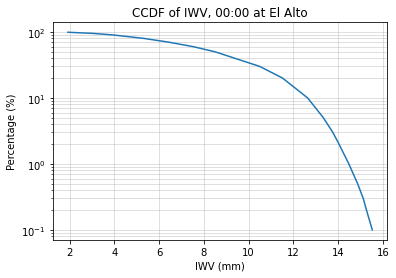

In [74]:
X, ccdf = plotcdf(tt, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of IWV, 00:00 at El Alto')
plt.xlabel('IWV (mm)')
plt.ylabel('Percentage (%)')
plt.show()

In [81]:
at_20, at_40, at_50, at_75 = calc_at(Xn, [20, 40, 50, 75], -16.51, -68.17)

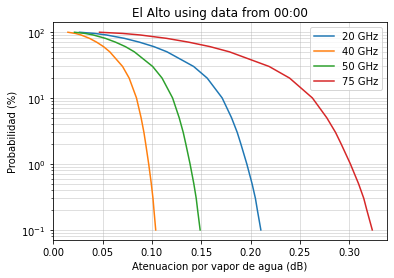

In [86]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(at_20, prob_nom, label='20 GHz')
plt.semilogy(at_40, prob_nom, label='40 GHz')
plt.semilogy(at_50, prob_nom, label='50 GHz')
plt.semilogy(at_75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto using data from 00:00')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [83]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, at_20, at_40, at_50, at_75]), columns=dfindex)
outputpath = '/home/gustavo/Downloads/tcwv/interp/0/'
name = 'CCDF_ERA5-00.csv'
results.to_csv(outputpath + name, index=False)

### Data for 12:00

In [94]:
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []
t7 = []
loadlist(t1, '/home/gustavo/Downloads/tcwv/interp/1200/1-itcwv_12.txt')
loadlist(t2, '/home/gustavo/Downloads/tcwv/interp/1200/2-itcwv_12.txt')
loadlist(t3, '/home/gustavo/Downloads/tcwv/interp/1200/3-itcwv_12.txt')
loadlist(t4, '/home/gustavo/Downloads/tcwv/interp/1200/4-itcwv_12.txt')
loadlist(t5, '/home/gustavo/Downloads/tcwv/interp/1200/5-itcwv_12.txt')
loadlist(t6, '/home/gustavo/Downloads/tcwv/interp/1200/6-itcwv_12.txt')
loadlist(t7, '/home/gustavo/Downloads/tcwv/interp/1200/7-itcwv_12.txt')

tt = t1 + t2 + t3 + t4 + t5 + t6 + t7

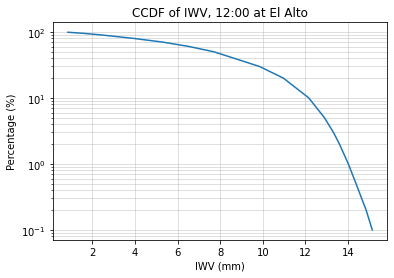

In [95]:
X, ccdf = plotcdf(tt, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of IWV, 12:00 at El Alto')
plt.xlabel('IWV (mm)')
plt.ylabel('Percentage (%)')
plt.show()

In [97]:
at_20, at_40, at_50, at_75 = calc_at(Xn, [20, 40, 50, 75], -16.51, -68.17)

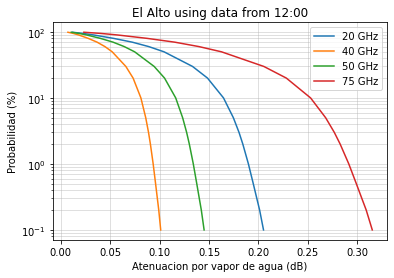

In [98]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(at_20, prob_nom, label='20 GHz')
plt.semilogy(at_40, prob_nom, label='40 GHz')
plt.semilogy(at_50, prob_nom, label='50 GHz')
plt.semilogy(at_75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto using data from 12:00')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [99]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, at_20, at_40, at_50, at_75]), columns=dfindex)
outputpath = '/home/gustavo/Downloads/tcwv/interp/1200/'
name = 'CCDF_ERA5-1200.csv'
results.to_csv(outputpath + name, index=False)

In [107]:
hourarray = np.arange(0,2400,100).tolist()
strhour = [str(i) for i  in hourarray]
path = '/home/gustavo/Downloads/tcwv/interp/'

tt = []
for i in strhour:
    for j in os.listdir(path + i):
        loadlist(tt, path + i + '/' + j)

len(tt)

613608

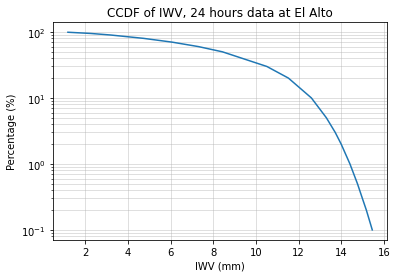

In [109]:
X, ccdf = plotcdf(tt, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of IWV, 24 hours data at El Alto')
plt.xlabel('IWV (mm)')
plt.ylabel('Percentage (%)')
plt.show()

In [110]:
at_20, at_40, at_50, at_75 = calc_at(Xn, [20, 40, 50, 75], -16.51, -68.17)

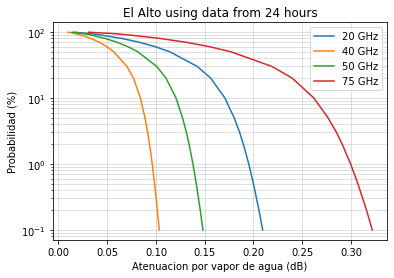

In [111]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(at_20, prob_nom, label='20 GHz')
plt.semilogy(at_40, prob_nom, label='40 GHz')
plt.semilogy(at_50, prob_nom, label='50 GHz')
plt.semilogy(at_75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto using data from 24 hours')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [112]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, at_20, at_40, at_50, at_75]), columns=dfindex)
outputpath = '/home/gustavo/Downloads/tcwv/interp/csv-results/'
name = 'CCDF_ERA5-00-24.csv'
results.to_csv(outputpath + name, index=False)

In [113]:
df0 = pd.read_csv('/home/gustavo/Downloads/tcwv/interp/csv-results/CCDF_ERA5-00.csv')
df12 = pd.read_csv('/home/gustavo/Downloads/tcwv/interp/csv-results/CCDF_ERA5-1200.csv')
dft = pd.read_csv('/home/gustavo/Downloads/tcwv/interp/csv-results/CCDF_ERA5-00-24.csv')

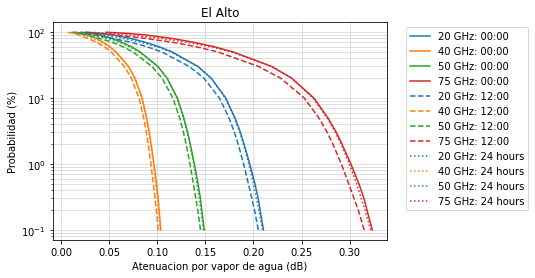

In [115]:
plt.grid(True, which="both", alpha=0.5)
#plt.xlim(0, 0.6)
plt.semilogy(df0['A20'], prob_nom, label='20 GHz: 00:00')
plt.semilogy(df0['A40'], prob_nom, label='40 GHz: 00:00')
plt.semilogy(df0['A50'], prob_nom, label='50 GHz: 00:00')
plt.semilogy(df0['A75'], prob_nom, label='75 GHz: 00:00')
plt.semilogy(df12['A20'], prob_nom, label='20 GHz: 12:00', ls='--', c='C0')
plt.semilogy(df12['A40'], prob_nom, label='40 GHz: 12:00', ls='--', c='C1')
plt.semilogy(df12['A50'], prob_nom, label='50 GHz: 12:00', ls='--', c='C2')
plt.semilogy(df12['A75'], prob_nom, label='75 GHz: 12:00', ls='--', c='C3')
plt.semilogy(dft['A20'], prob_nom, label='20 GHz: 24 hours', ls=':', c='C0')
plt.semilogy(dft['A40'], prob_nom, label='40 GHz: 24 hours', ls=':', c='C1')
plt.semilogy(dft['A50'], prob_nom, label='50 GHz: 24 hours', ls=':', c='C2')
plt.semilogy(dft['A75'], prob_nom, label='75 GHz: 24 hours', ls=':', c='C3')
#plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('El Alto')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [118]:
display(dft)

,Probabilities,IWV,A20,A40,A50,A75
0,0.1,15.455952,0.209481,0.103330,0.148176,0.321941
1,0.2,15.177486,0.205693,0.101430,0.145449,0.316013
2,0.3,14.992287,0.203174,0.100168,0.143639,0.312080
3,0.5,14.762521,0.200050,0.098606,0.141398,0.307211
4,1.0,14.408245,0.195235,0.096205,0.137953,0.299725
5,2.0,13.996455,0.189641,0.093423,0.133964,0.291057
6,3.0,13.718849,0.185872,0.091554,0.131283,0.285234
7,5.0,13.303772,0.180238,0.088767,0.127289,0.276557
8,10.0,12.600654,0.170702,0.084071,0.120558,0.261938
9,20.0,11.522077,0.156089,0.076922,0.110318,0.239703


In [12]:
hour = '1200'
path = 'TCWV/ElAlto/Data-50-19/'
tt12 = []

for j in os.listdir(path + hour):
    loadlist(tt12, path + hour + '/' + j)

len(tt12)

25567

In [14]:
aux = 0
ranges = [0]
for i in range(7):
    print(len(create_dates(1950 + 10*i, 1959 + 10*i)[0]))
    aux += len(create_dates(1950 + 10*i, 1959 + 10*i)[0])
    ranges.append(aux)
    #print(aux)
print(ranges)

3652
3653
3652
3653
3652
3653
3652
[0, 3652, 7305, 10957, 14610, 18262, 21915, 25567]


In [32]:
a = np.arange(1,18,1).tolist()
b = [0,2,5,7,10,12,15,17]
t = [0]*7
for i in range(len(t)):
    t[i] = a[b[i]:b[i+1]]
    
print(t)

[[1, 2], [3, 4, 5], [6, 7], [8, 9, 10], [11, 12], [13, 14, 15], [16, 17]]


In [22]:
decades = [0] * 7
for i in range(len(decades)):
    #print(ranges[i])
    #print(ranges[i+1])
    decades[i] = tt12[ranges[i]:ranges[i+1]]
    print(len(decades[i]))

3652
3653
3652
3653
3652
3653
3652


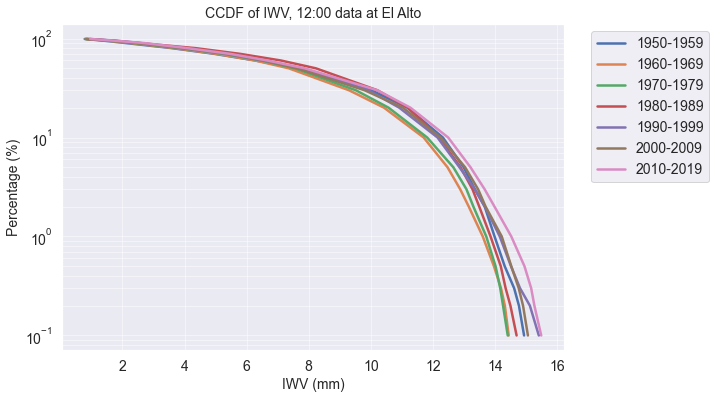

In [132]:
d1 = np.array(decades[0])
d2 = np.array(decades[1])
d3 = np.array(decades[2])
d4 = np.array(decades[3])
d5 = np.array(decades[4])
d6 = np.array(decades[5])
d7 = np.array(decades[6])

X = [0] * 7
ccdf = [0] * 7
Xn = [0] * 7
means = [0] * 7
std = [0] * 7
ys = []

for i in range(len(decades)):
    means[i] = np.mean(decades[i])
    std[i] = np.std(decades[i])
    X[i], ccdf[i] = plotcdf(decades[i], 0)
    Xn[i] = interp_list(ccdf[i], X[i], prob_nom)
    
for i in range(len(Xn)):
    lt = str(1950 + i * 10) + '-' + str(1959 + i * 10)
    ys.append(lt)
    plt.semilogy(Xn[i], prob_nom, label = lt, linewidth = 2.5)
    
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of IWV, 12:00 data at El Alto', fontsize = 14)
plt.xlabel('IWV (mm)', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

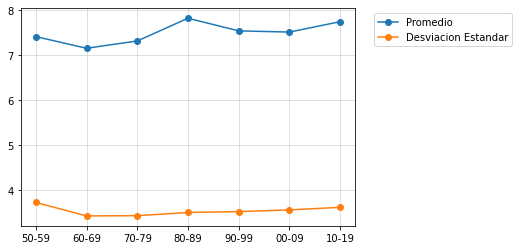

In [79]:
nys = [i[2:5]+i[7:] for i in ys]
plt.grid(True, which="both", alpha=0.5)
plt.plot(nys, means, '-o', label='Promedio')
plt.plot(nys, std, '-o', label='Desviacion Estandar')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Fig2.png')
plt.show()

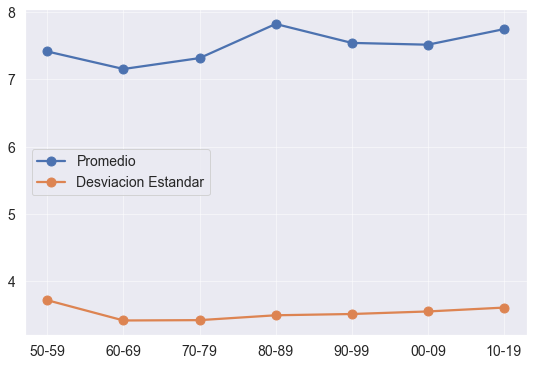

In [120]:
nys = [i[2:5]+i[7:] for i in ys]
plt.grid(True, which="both", alpha=0.5)
plt.plot(nys, means, '-o', label='Promedio')
plt.plot(nys, std, '-o', label='Desviacion Estandar')
plt.legend(loc=6)
plt.savefig('Fig2.png')
plt.show()

In [20]:
from datetime import date, timedelta

In [38]:
sdate = date(2016,6,1)
edate = date(2020,5,29)
ranges = pd.date_range(sdate,edate-timedelta(days=1),freq='B').strftime("%Y%m%d").tolist()
len(ranges)

1042

In [36]:
len(pd.read_csv('RAOB/RAOB.csv'))

946

In [46]:
datefs = pd.date_range('2020-09-16', '2020-11-16', freq='d').strftime('%Y%m%d').tolist()
a = 1979
a = '2012-01-26'
if isinstance(a, int):
    print('Int number')
else:
    print('Non int number')

Non int number


In [52]:
startyear = '2016-06-01'
endyear = '2020-05-29'
hourarray = [1200]
latitude = -16.51
longitude = -68.17
inputpath = 'RawData/WVAt/tcwv_ea_comp.grib'
outputpath = 'TCWV/ElAlto/'
find_iv(inputpath, outputpath, startyear, endyear, hourarray, latitude, longitude, datafreq='B', outputname='itcwv_comp')

--- 7.0971 seconds ---


### Data from ERA5 for comparison purposes

In [58]:
t = []
loadlist(t, 'TCWV/ElAlto/itcwv_comp_12.txt')

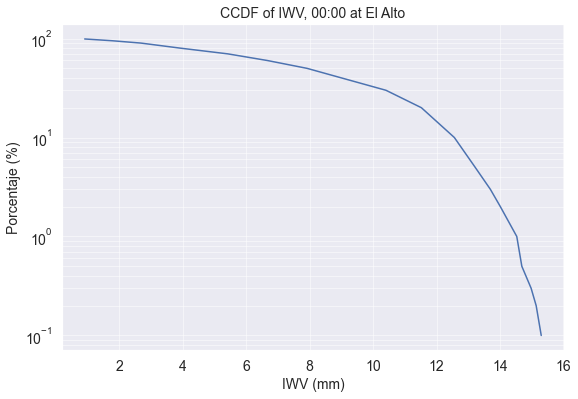

In [67]:
X, ccdf = plotcdf(t, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of IWV, 00:00 at El Alto')
plt.xlabel('IWV (mm)')
plt.ylabel('Porcentaje (%)')
plt.show()

In [68]:
at_20, at_40, at_50, at_75 = calc_at(Xn, [20, 40, 50, 75], -16.51, -68.17)

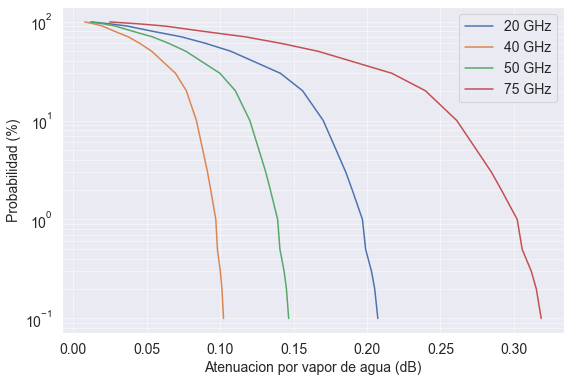

In [71]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(at_20, prob_nom, label='20 GHz')
plt.semilogy(at_40, prob_nom, label='40 GHz')
plt.semilogy(at_50, prob_nom, label='50 GHz')
plt.semilogy(at_75, prob_nom, label='75 GHz')
plt.legend(loc='best')
#plt.title('El Alto using data from 00:00')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [73]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, at_20, at_40, at_50, at_75]), columns=dfindex)
outputpath = 'TCWV/ElAlto/'
name = 'CCDF_ERA5-16-20.csv'
results.to_csv(outputpath + name, index=False)

### Data comparison